# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve)
from collections import Counter
import joblib

In [2]:
data = pd.read_csv('/kaggle/input/bengali-sms-dataset/bangla_smish.csv')
data.rename(columns={'label': 'Label'}, inplace=True)
data

,Label,text
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...
1,normal,আপনার দিন কেমন কাটছে?
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও..."
3,normal,"হ্যালো, কি খবর?"
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...
...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ..."
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!
2285,normal,আপনার কেমন দিন কাটছে?


In [3]:
data.head()

,Label,text
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...
1,normal,আপনার দিন কেমন কাটছে?
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও..."
3,normal,"হ্যালো, কি খবর?"
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...


In [4]:
data.shape

(2287, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287 entries, 0 to 2286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   2287 non-null   object
 1   text    2287 non-null   object
dtypes: object(2)
memory usage: 35.9+ KB


In [6]:
def clean_text(text):
    text = re.sub('[^\u0980-\u09FF]',' ',text)
    text = re.sub('[?.`*^()!°¢܌Ͱ̰ߒנ~×Ҡߘ:ҰߑÍ|।;!,&%\'@#$><A-Za-z0+-9=./''""_৳]', '', text)
    text = re.sub(r'(\W)(?=\1)', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'ߑͰߑ̰ߒנ', '', text)
    text = re.sub(r'ߎɰߎɰߎɍ', '', text)
    return text

In [7]:
data['Cleaned'] = data['text'].apply(clean_text)

In [8]:
data

,Label,text,Cleaned
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা জরুরি...
1,normal,আপনার দিন কেমন কাটছে?,আপনার দিন কেমন কাটছে
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও...",৪৫ ক্যাশব্যাক ৪৬জিবি ৪৫৩ ৩০দিন নিয়ে নাও এখনই
3,normal,"হ্যালো, কি খবর?",হ্যালো কি খবর
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে কল করুন
...,...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...,বোনাস সহ ৩জিবি ৬০টাকা ৩দিন ডায়াল ১২১ ৫৬৯৯ বা
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ...",নতুন স্যামসাং ফোনে ১০ ডিসকাউন্ট স্টক সীমিত আজই...
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!,শুভ অসুস্থ্য দিনের শুভেচ্ছা
2285,normal,আপনার কেমন দিন কাটছে?,আপনার কেমন দিন কাটছে


In [9]:
stopword_ls ='/kaggle/input/stop-words/stopwords-bn.txt'

In [10]:
def stopword_removal(text,stpwrd= stopword_ls):
    stp,num_of_stopwords =stopwords_info(stpwrd)
    result = text.split()
    Comments = [word.strip() for word in result if word not in stp ]
    Comments =" ".join(Comments)
    return Comments

In [11]:
def stopwords_info(filename):
    stp = open(filename,'r',encoding='utf-8').read().split()
    num_of_stopwords = len(stp)
    return stp,num_of_stopwords

In [12]:
data['Cleaned'] = data['Cleaned'].apply(stopword_removal)  
data

,Label,text,Cleaned
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...,বাংলাদেশ ব্যাংক গুরুত্বপূর্ণ বার্তা জরুরি ভিত্...
1,normal,আপনার দিন কেমন কাটছে?,কেমন কাটছে
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও...",৪৫ ক্যাশব্যাক ৪৬জিবি ৪৫৩ ৩০দিন নাও এখনই
3,normal,"হ্যালো, কি খবর?",হ্যালো খবর
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা কল করুন
...,...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...,বোনাস ৩জিবি ৬০টাকা ৩দিন ডায়াল ১২১ ৫৬৯৯
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ...",স্যামসাং ফোনে ১০ ডিসকাউন্ট স্টক সীমিত আজই কিনুন
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!,শুভ অসুস্থ্য দিনের শুভেচ্ছা
2285,normal,আপনার কেমন দিন কাটছে?,কেমন কাটছে


In [13]:
data['length'] = data['Cleaned'].apply(lambda x:len(x.split()))
dataset = data.loc[data.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Text".format(len(data)-len(dataset)),
      "\nTotal Text:",len(dataset))

After Cleaning: 
Removed 28 Small Text 
Total Text: 2259


In [14]:
def data_summary(df):
    class_counts = df['Label'].value_counts()
    total_unique_words = set(word for text in df['Cleaned'] for word in text.lower().split())
    print(f"Total Unique Words: {len(total_unique_words)}\n")
    
    for label, count in class_counts.items():
        subset = df[df['Label'] == label]
        words = [word for text in subset['Cleaned'] for word in text.lower().split()]
        word_counts = Counter(words)
        unique_words = len(word_counts)
        most_common = word_counts.most_common(10)
        
        print(f"Class: {label}")
        print(f"Documents: {count}")
        print(f"Words: {len(words)}")
        print(f"Unique Words: {unique_words}\n")
        print("Most Frequent Words:")
        for word, freq in most_common:
            print(f"{word}: {freq}")
        print()

data_summary(dataset)

Total Unique Words: 3320

Class: smish
Documents: 909
Words: 9529
Unique Words: 1625

Most Frequent Words:
করুন: 796
টাকা: 355
ক্লিক: 286
কল: 238
ব্যাংক: 144
ইনকাম: 125
০০০: 121
বিস্তারিত: 109
বাজি: 97
ধরুন: 97

Class: normal
Documents: 904
Words: 3660
Unique Words: 1185

Most Frequent Words:
নাম্বারে: 98
টাকা: 94
কেমন: 93
করুন: 79
শুভ: 70
না: 54
ভালো: 52
কল: 43
খবর: 41
আছি: 38

Class: promo
Documents: 446
Words: 4009
Unique Words: 1122

Most Frequent Words:
৩০দিন: 152
১২১: 75
ক্যাশব্যাক: 71
নাও: 70
ডায়াল: 70
করুন: 59
অফার: 56
বোনাস: 46
ছাড়: 45
ডিসকাউন্ট: 45



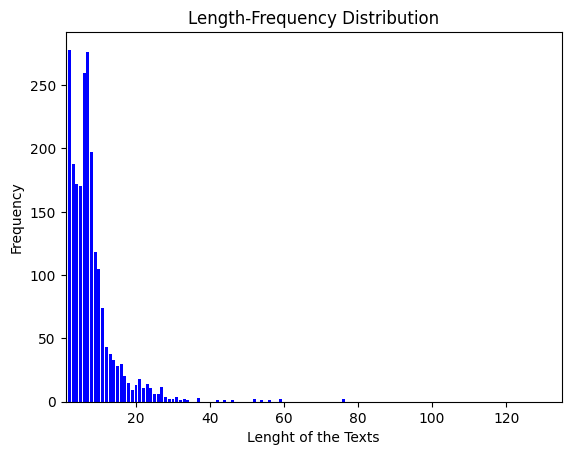

Maximum Length of a Text: 76
Minimum Length of a Text: 1
Average Length of a Text: 8.0


In [15]:
dataset['TextLength'] = dataset.Cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a Text: {max(dataset.TextLength)}")
print(f"Minimum Length of a Text: {min(dataset.TextLength)}")
print(f"Average Length of a Text: {round(np.mean(dataset.TextLength),0)}")

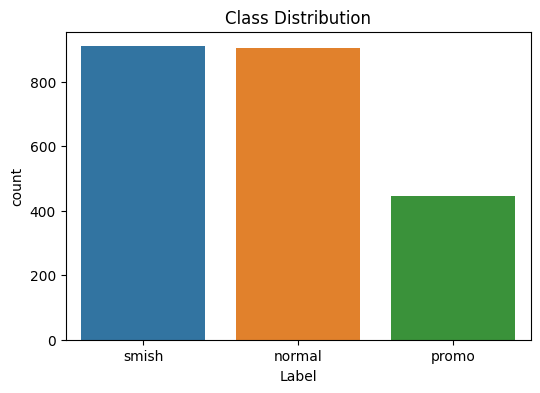

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(data=dataset, x='Label')
plt.title('Class Distribution')
plt.show()

In [17]:
dataset.groupby('Label').size().reset_index(name='counts')

,Label,counts
0,normal,904
1,promo,446
2,smish,909


# 0 = Normal, 1 = Promo, 2 = Smish

In [18]:
le = LabelEncoder()
dataset['Encoded_Label'] = le.fit_transform(dataset['Label'])
print(f"Classes: {le.classes_}")

Classes: ['normal' 'promo' 'smish']


In [19]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x.split(), use_idf=True, token_pattern=None)
X = tfidf.fit_transform(dataset['Cleaned'])
y = dataset['Encoded_Label'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=22, stratify=y
)
print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 1807, Testing Samples: 452


In [21]:
models = {
    'Logistic Regression': LogisticRegression(random_state=123, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', random_state=0, max_depth=1, min_samples_split=25),
    'Random Forest': RandomForestClassifier(criterion='entropy', random_state=13),
    'Naive Bayes': MultinomialNB(alpha=0.431),
    'KNN': KNeighborsClassifier(n_neighbors=100, algorithm='ball_tree', n_jobs=-1),
    'Linear SVM': SVC(kernel='linear', C=0.2, probability=True, random_state=0),
    'RBF SVM': SVC(kernel='rbf', C=1000, gamma=0.00015, probability=True, random_state=0),
    'SGD': SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-3)
}

In [22]:
import warnings
warnings.filterwarnings('ignore')

performance = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    performance[name] = {
        'Accuracy': accuracy_score(y_test, y_pred) * 100,
        'Precision': precision_score(y_test, y_pred, average='micro') * 100,
        'Recall': recall_score(y_test, y_pred, average='micro') * 100,
        'F1 Score': f1_score(y_test, y_pred, average='micro') * 100
    }
    print(f"{name} evaluated.")

Logistic Regression evaluated.
Decision Tree evaluated.
Random Forest evaluated.
Naive Bayes evaluated.
KNN evaluated.
Linear SVM evaluated.
RBF SVM evaluated.
SGD evaluated.


In [23]:
performance_df = (
    pd.DataFrame(performance)
    .T[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
    .round(2)
    .style
    .apply(
        lambda s: ['background-color: lightgreen' if v == s.max() else '' for v in s],
        subset=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        axis=0
    )
    .format(precision=2)
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
)

performance_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,94.91,94.91,94.91,94.91
Decision Tree,68.81,68.81,68.81,68.81
Random Forest,96.02,96.02,96.02,96.02
Naive Bayes,96.46,96.46,96.46,96.46
KNN,87.83,87.83,87.83,87.83
Linear SVM,93.36,93.36,93.36,93.36
RBF SVM,93.81,93.81,93.81,93.81
SGD,97.12,97.12,97.12,97.12


In [30]:
if name == 'SGD':
        joblib.dump(model, 'sgd_model.pkl')
        print("SGD model saved successfully.")

SGD model saved successfully.


# TESTING

In [24]:
test_sentences = [
    # Previous sentences
    "এখনই আমাদের নতুন অফারগুলির জন্য আমাদের ওয়েবসাইটে ভিজিট করুন এবং বিশেষ ছাড় পান!",  # Promo
    "শুধুমাত্র আজকের জন্য: সমস্ত প্রোডাক্টে ৩০% ছাড়। দেরি করবেন না!",  # Promo
    "নতুন কোলগেটের পণ্য কিনলে দ্বিতীয়টি বিনামূল্যে পাবেন। অফার সীমিত সময়ের জন্য।",  # Promo
    "আমাদের মেসেজিং সার্ভিসে নিবন্ধন করুন এবং প্রতি মাসে বিনামূল্যে ৫০০ টাকায় কথা বলার সুযোগ পান!",  # Promo
    "আপনার ব্যাংক অ্যাকাউন্ট সুরক্ষিত করতে এই লিঙ্কে ক্লিক করুন। আপনার বিবরণ দিন, না হলে সমস্যা হবে!",  # Smish
    "আপনি জিতেছেন ১০,০০০ টাকা! আপনার পুরস্কার নিতে এখানে ক্লিক করুন।",  # Smish
    "আমরা জানাচ্ছি যে আপনার অ্যাকাউন্টে সন্দেহজনক কার্যকলাপ হয়েছে। আপনার তথ্য যাচাই করতে তাড়াতাড়ি এই লিঙ্কে যান।",  # Smish
    "আজ সকালে আমি বাজারে গিয়েছিলাম এবং সবজিগুলো কিনে নিয়েছি।",  # Normal
    "আমার ছোট ভাই আজ প্রথমবার স্কুলে গিয়েছে, সে খুব উচ্ছ্বসিত।",  # Normal
    "বিকেলে আমি একটি বই পড়েছি এবং গল্পটি খুব ভালো লেগেছে।",  # Normal
    
    # New sentences
    "এখনই আমাদের নতুন ডিজিটাল ক্যামেরার ওপর ২০% ডিসকাউন্ট পাবেন, তাই দেরি করবেন না!",  # Promo
    "সপ্তাহের শেষ পর্যন্ত আপনার প্রিয় শপিং স্টোরে ১৫% ছাড়। সীমিত সময়ের অফার!",  # Promo
    "আমাদের নতুন মোবাইল ফোন কিনুন এবং প্রথম ১০০ গ্রাহকের জন্য এক্সক্লুসিভ উপহার!",  # Promo
    "নতুন পিৎজা লাঞ্চ অফার কিনুন, দ্বিতীয়টি ৫০% ছাড়ে পান!",  # Promo
    "স্বাস্থ্যকর পানীয় কিনুন এবং কিনুন, পান করুন ১০% ছাড়ে।",  # Promo
    "প্রতি মাসে বিনামূল্যে ১,০০০ টাকা রিচার্জ অফার নিয়ে আসছে, আজই নিবন্ধন করুন!",  # Promo
    "বিক্রয়ের সময় আমাদের ফ্যাশনেবল পোশাকের জন্য সেরা দামগুলো পেতে আজই আসুন!",  # Promo
    "নতুন কোর্সে ভর্তি হলে ২৫% ছাড় পান, দ্রুত রেজিস্ট্রেশন করুন!",  # Promo
    "আপনার ব্যাংক অ্যাকাউন্ট সুরক্ষিত করার জন্য এখনই এই লিঙ্কে ক্লিক করুন!",  # Smish
    "আপনি জিতেছেন একটি নতুন গাড়ি! আপনার নাম নিশ্চিত করতে দ্রুত ক্লিক করুন।",  # Smish
    "আপনার মোবাইল নম্বর থেকে ১,০০০ টাকা কেটে নেওয়া হয়েছে! তাড়াতাড়ি আমাদের সাথে যোগাযোগ করুন।",  # Smish
    "আপনার তথ্য আপডেট করতে আমাদের লিঙ্কে ক্লিক করুন, না হলে অ্যাকাউন্ট বন্ধ হয়ে যাবে।",  # Smish
    "বিশেষ অফার! আজই একটি লগইন করে ৫০০ টাকা ক্যাশব্যাক পান।",  # Smish
    "আপনার পুরানো মুঠোফোনে বিপুল ছাড়ের অফার। দেরি করবেন না, ফর্ম পূরণ করুন!",  # Smish
    "বিকেলে আমি পার্কে হাঁটতে গিয়েছিলাম এবং অনেক মজার সময় কাটিয়েছি।",  # Normal
    "আজ আমি একটা নতুন বই পড়েছি এবং সেটি সত্যিই চিত্তাকর্ষক ছিল।",  # Normal
    "আমার দিদি আজকে একটি নতুন রান্নার রেসিপি চেষ্টা করেছে এবং খাবারটি সুস্বাদু হয়েছে।",  # Normal
    "স্কুলে আমরা একটি নতুন প্রকল্প শুরু করেছি এবং সবাই খুব উৎসাহী।",  # Normal
    "গত রাতে আমি একটি সিনেমা দেখেছি এবং সেটি খুবই ভালো ছিল।",  # Normal
    "মার্কেট থেকে সবজি কিনে বাড়ি ফিরে এসেছি এবং রান্নার প্রস্তুতি নিচ্ছি।"  # Normal
]

In [25]:
cleaned_test_sentences = [clean_text(sentence) for sentence in test_sentences]
cleaned_test_sentences = [stopword_removal(sentence) for sentence in cleaned_test_sentences]

In [26]:
X_test_transformed = tfidf.transform(cleaned_test_sentences)

In [27]:
sgd_model = models['SGD']  # Assuming your SGD model is stored in the models dictionary
predictions = sgd_model.predict(X_test_transformed)

In [28]:
predicted_labels = le.inverse_transform(predictions)

In [29]:
for sentence, label in zip(test_sentences, predicted_labels):
    print(f"Sentence: '{sentence}' - Predicted Label: '{label}'")

Sentence: 'এখনই আমাদের নতুন অফারগুলির জন্য আমাদের ওয়েবসাইটে ভিজিট করুন এবং বিশেষ ছাড় পান!' - Predicted Label: 'promo'
Sentence: 'শুধুমাত্র আজকের জন্য: সমস্ত প্রোডাক্টে ৩০% ছাড়। দেরি করবেন না!' - Predicted Label: 'promo'
Sentence: 'নতুন কোলগেটের পণ্য কিনলে দ্বিতীয়টি বিনামূল্যে পাবেন। অফার সীমিত সময়ের জন্য।' - Predicted Label: 'promo'
Sentence: 'আমাদের মেসেজিং সার্ভিসে নিবন্ধন করুন এবং প্রতি মাসে বিনামূল্যে ৫০০ টাকায় কথা বলার সুযোগ পান!' - Predicted Label: 'smish'
Sentence: 'আপনার ব্যাংক অ্যাকাউন্ট সুরক্ষিত করতে এই লিঙ্কে ক্লিক করুন। আপনার বিবরণ দিন, না হলে সমস্যা হবে!' - Predicted Label: 'smish'
Sentence: 'আপনি জিতেছেন ১০,০০০ টাকা! আপনার পুরস্কার নিতে এখানে ক্লিক করুন।' - Predicted Label: 'smish'
Sentence: 'আমরা জানাচ্ছি যে আপনার অ্যাকাউন্টে সন্দেহজনক কার্যকলাপ হয়েছে। আপনার তথ্য যাচাই করতে তাড়াতাড়ি এই লিঙ্কে যান।' - Predicted Label: 'smish'
Sentence: 'আজ সকালে আমি বাজারে গিয়েছিলাম এবং সবজিগুলো কিনে নিয়েছি।' - Predicted Label: 'normal'
Sentence: 'আমার ছোট ভাই আজ প্রথমবার স্কুল